(572, 380)
torch.Size([1, 3, 380, 572])


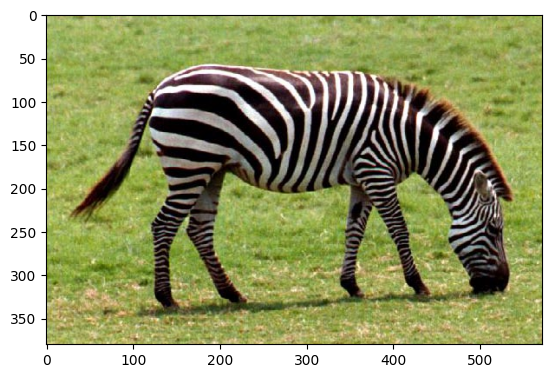

In [9]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

torch.cuda.set_device(1)

zebra_img = Image.open("images/zebra.png")
# zebra_img = Image.open("output/zebra_random_sample.png")
print(zebra_img.size)
preprocess = transforms.Compose([
   transforms.ToTensor(),
])
zebra_tensor = preprocess(zebra_img)[None,:,:,:]

print(zebra_tensor.shape)
plt.imshow(zebra_tensor[0].numpy().transpose(1,2,0));

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [3]:
pred = model(norm(zebra_tensor))

In [5]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

print(imagenet_classes[pred.max(dim=1)[1].item()])

zebra


In [6]:
import torch.optim as optim
epsilon = 1/100

delta = torch.zeros_like(zebra_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-1)

for t in range(50):
    pred = model(norm(zebra_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([340]))
    if t % 5 == 0:
        print(t, "Loss =", loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,340].item())

0 Loss = -0.16548670828342438
5 Loss = -7.670555114746094
10 Loss = -11.725605010986328
15 Loss = -14.21791934967041
20 Loss = -17.39775276184082
25 Loss = -17.515892028808594
30 Loss = -20.232410430908203
35 Loss = -19.4937744140625
40 Loss = -17.462404251098633
45 Loss = -19.2415771484375
True class probability: 1.3751406680029277e-09


Predicted class:  croquet_ball
Predicted probability: 0.9999781847000122


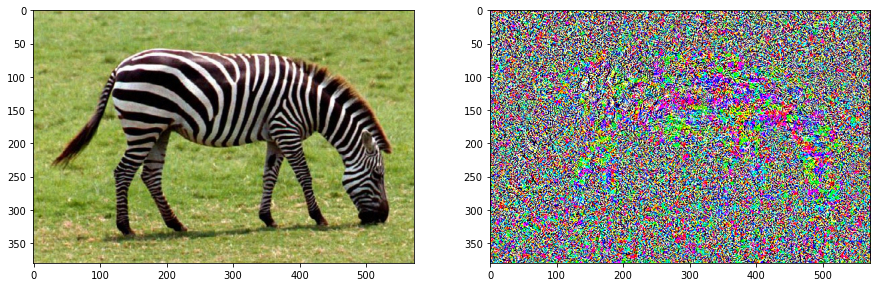

In [8]:
pred = model(norm(zebra_tensor + delta))
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
result = (zebra_tensor+delta)[0].detach().numpy().transpose(1,2,0)
# clip to 0.0-1.0
result = np.clip(result, 0.0, 1.0)

plt.imsave("./perturbed_img/zebra_perturbed.png", result)

fig, axes = plt.subplots(1,2, figsize=(15,15))

axes[0].imshow(result)
axes[1].imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0));

In [16]:
%%time
! CUDA_VISIBLE_DEVICE=9
! python main.py --task='image' --image_name='zebra_perturbed.png' --run_name='zebra'
! python sample.py --task='image' --image_name='zebra_perturbed.png' --run_name='zebra' [--sample_count=8]

available_gpus=0
diffusion_timesteps=50
frame_diff=1
image_name=zebra_perturbed.png
initial_lr=0.0002
interpolation_rate=4
network_depth=16
network_filters=64
output_dir=outputs
output_video_len=100
project_name=SinFusion
run_name=zebra
sample_count=1
sample_size=None
start_frame_index=None
task=image
Sample directory: outputs/zebra_perturbed.png/zebra/
Traceback (most recent call last):
  File "sample.py", line 211, in <module>
    main()
  File "sample.py", line 207, in main
    generate_diverse_samples(cfg)
  File "sample.py", line 174, in generate_diverse_samples
    model = Diffusion.load_from_checkpoint(path, model=NextNet(depth=cfg.network_depth),
  File "/cis/home/tlu32/anaconda3/envs/SinFusion/lib/python3.8/site-packages/pytorch_lightning/core/saving.py", line 134, in load_from_checkpoint
    checkpoint = pl_load(checkpoint_path, map_location=lambda storage, loc: storage)
  File "/cis/home/tlu32/anaconda3/envs/SinFusion/lib/python3.8/site-packages/pytorch_lightning/utilities/c

(572, 380)
torch.Size([1, 3, 380, 572])


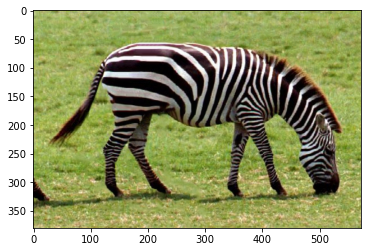

In [16]:
zebra_perturbed_img = Image.open("output/zebra_perturbed_random_sample.png")
# zebra_img = Image.open("output/zebra_random_sample.png")
print(zebra_perturbed_img.size)
preprocess = transforms.Compose([
   transforms.ToTensor(),
])
zebra_perturbed_tensor = preprocess(zebra_perturbed_img)[None,:,:,:]

print(zebra_perturbed_tensor.shape)
plt.imshow(zebra_perturbed_tensor[0].numpy().transpose(1,2,0));

In [17]:
pred = model(norm(zebra_perturbed_tensor))
print(imagenet_classes[pred.max(dim=1)[1].item()])

zebra
